# DATASCI W261: Machine Learning at Scale 

**Name: Carlos Eduardo Rodriguez Castillo**

**email: cerodriguez@berkeley.edu**

**Week 5**

**Section 2**

## HW 5.0
- What is a data warehouse? What is a Star schema? When is it used?

## HW 5.1
- In the database world what is 3NF? Does machine learning use data in 3NF? If so why? 
- In what form does ML consume data?
- Why would one use log files that are denormalized?

##### ANSWER:

* In the database world, 3NF is a format of ...
* ML consumes data in a de-normalized format...
* One would use log files that are denormalized...

## HW 5.2
Using MRJob, implement a hashside join (memory-backed map-side) for left, right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

- (1) Left joining Table Left with Table Right
- (2) Right joining Table Left with Table Right
- (3) Inner joining Table Left with Table Right


##### ANSWER:

I choose the table with the URLs (URL ID and URL name) as the Left table in the hashside join because it is considerably smaller than the URL ID and USER ID visits; by definition we wish to store the smallest of the tables being merged as the in-memory stored table.

| |Inner Join|Left Outer Join|Right Outer Join|
|---|---|---|---|
|Number of rows|98654|98663|98654| |


In [10]:
#####################################
## Preprocessing/housekeeping
#####################################
#!mkdir data
#!mkdir src
#!wget "https://www.dropbox.com/sh/m0nxsf4vs5cyrp2/AADCHtrJ4CBCDO1po_OAWg0ia/anonymous-msweb.data?dl=0#"
#!ls
#!mv "anonymous-msweb.data?dl=0" data/anonymous-msweb.data
#!ls data

!egrep "^A," data/anonymous-msweb.data > data/URL_table.txt
#!head data/URL_table.txt
#!wc -l data/URL_table.txt

In [6]:
%%writefile src/preprocess.py
#!/usr/bin/python
"""
Single node data preprocessing for HW4.2
"""
__author__ = "Carlos Eduardo Rodriguez Castillo"
__email__ = "cerodriguez@berkeley.edu"

import sys
import re

url_dict = {}

for line in sys.stdin:
    line = line.strip()
    elements = line.split(",")
    ## Given the design of the raw data file, 
    ## the script will first populate the url_dict
    if elements[0] == 'C':
        visitor_data = elements[0] + ',' + elements[2]
        continue
    elif elements[0] == 'V':
        ## this is formatted as 'V,[URL_ID],[URL]
        visit_data = elements[0] + ',' + elements[1]
        ## this is formatted as 'V,[URL_ID],[URL],C,[USER_ID]
        processed_line = visit_data + ',' + visitor_data
        print processed_line

Writing src/preprocess.py


In [7]:
!chmod a+x src/preprocess.py
!./src/preprocess.py < data/anonymous-msweb.data \
> data/preprocessed_anonymous-msweb.data

In [3]:
%%writefile src/InnerJoinMRjob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os

class InnerJoinMRjob(MRJob):
    
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper
            )
        ]
    COUNTER = 0
    in_memory_hash = {}
    def mapper_init(self):
#         print "Current path:", os.path.dirname(os.path.realpath(__file__))
        temp = [s.split('\n')[0].split(',') for s in open("/home/cloudera/w261/HW5/data/URL_table.txt", "r").readlines()]
        for row in temp:
            self.in_memory_hash[row[1]] = 'http://www.microsoft.com' + row[4].strip('"')
    
    def identity_mapper(self, _, line):
        yield _,line
    
    def mapper(self, _, line):
        line = line.strip()
        elements = line.split(',')
        url_id = elements[1]
        user_id = elements[3]
        url = self.in_memory_hash[url_id]
        yield url_id, (url, user_id)
    
if __name__ == '__main__':
    InnerJoinMRjob().run()

Overwriting src/InnerJoinMRjob.py


In [2]:
!chmod a+x src/InnerJoinMRjob.py
!./src/InnerJoinMRjob.py data/preprocessed_anonymous-msweb.data > output_InnerJoin

In [3]:
%%writefile src/RightOuterJoinMRjob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os

class RightOuterJoinMRjob(MRJob):
    
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper
            )
        ]
    COUNTER = 0
    in_memory_hash = {}
    def mapper_init(self):
#         print "Current path:", os.path.dirname(os.path.realpath(__file__))
        temp = [s.split('\n')[0].split(',') for s in open("/home/cloudera/w261/HW5/data/URL_table.txt", "r").readlines()]
        for row in temp:
            self.in_memory_hash[row[1]] = 'http://www.microsoft.com' + row[4].strip('"')
    
    def identity_mapper(self, _, line):
        yield _,line
    
    def mapper(self, _, line):
        line = line.strip()
        elements = line.split(',')
        url_id = elements[1]
        user_id = elements[3]
        try:
            url = self.in_memory_hash[url_id]
        except KeyError:
            sys.stderr.write("Did not find a URL for URL ID: %s"%url_id)
            url = "NULL"
        yield url_id, (url, user_id)
    
if __name__ == '__main__':
    RightOuterJoinMRjob().run()

Overwriting src/RightOuterJoinMRjob.py


In [4]:
!chmod a+x src/RightOuterJoinMRjob.py
!./src/RightOuterJoinMRjob.py data/preprocessed_anonymous-msweb.data > output_RightOuterJoin

No configs found; falling back on auto-configuration
Creating temp directory /tmp/RightOuterJoinMRjob.cloudera.20160615.211408.396808
Running step 1 of 1...
Streaming final output from /tmp/RightOuterJoinMRjob.cloudera.20160615.211408.396808/output...
Removing temp directory /tmp/RightOuterJoinMRjob.cloudera.20160615.211408.396808...


In [5]:
%%writefile src/LeftOuterJoinMRjob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os

class LeftOuterJoinMRjob(MRJob):
    
    def steps(self):
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 2,
            'stream.map.output.field.separator':',',
            'mapreduce.partition.keycomparator.options': "-k1,1 -k2,2r", # sort pages by count and then by ID
             'mapreduce.job.reduces': 1,
            'mapreduce.job.maps': 1
            
        }
        return [
            MRStep(jobconf=JOB_CONF_STEP,
                mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   mapper_final=self.mapper_final,
                   reducer=self.reducer
            )
        ]
    COUNTER = 0
    in_memory_hash = {}
    visited_hash = {}
    def mapper_init(self):
        temp = [s.split('\n')[0].split(',') for s in open("/home/cloudera/w261/HW5/data/URL_table.txt", "r").readlines()]
        for row in temp:
            self.in_memory_hash[row[1]] = {"url":'http://www.microsoft.com' + row[4].strip('"'),"visited":0}
            
    def identity_mapper(self, _, line):
        yield _,line
    
    def mapper(self, _, line):
        line = line.strip()
        elements = line.split(',')
        url_id = elements[1]
        user_id = elements[3]
        self.in_memory_hash[url_id]["visited"] = 1
        try:
            url = self.in_memory_hash[url_id]["url"]
        except KeyError:
            sys.stderr.write("Did not find a URL for URL ID: %s\n"%url_id)
            url = "NULL"
        yield (1, (url_id, url, user_id))
        
    def mapper_final(self):
        #non_visited_pages = []
        for key in self.in_memory_hash.keys():
            if self.in_memory_hash[key]["visited"] == 0:
                #print (key, (key, self.in_memory_hash[key]["url"], "NULL"))
                yield (99, (key, self.in_memory_hash[key]["url"], "NULL"))
#         non_visited_pages = [print (key, (key, self.visited_hash[key]["url"], "NULL")) if self.visited_hash[key]["visited"] == 0 for key in self.visited_hash.keys()]
#         for key in self.visited_hash.keys():
#             if self.visited_hash[key]["visited"] == 0:
#                 non_visited_pages.
#                 yield key, (url_id, url, "NULL") 
#         yield non_visited_pages
    def identity_reducer(self, visited, visit_tuples):
        prev_url_id = ""
        if int(visited) == 99:
            for vt in visit_tuples:
                url_id = vt[0]
                url = vt[1]
                uid = vt[2]
                yield visited, (url_id, url, uid)
        
    def reducer(self, visited, visit_tuples):
        prev_url_id = ""
        if int(visited) == 99:
            for vt in visit_tuples:
                url_id = vt[0]
                url = vt[1]
                if prev_url_id != url_id:
                    prev_url_id = url_id
                    yield url_id, (url,"NULL")
        else:
            for vt in visit_tuples:
                url_id = vt[0]
                url = vt[1]
                uid = vt[2]
                yield url_id, (url, uid)
    
if __name__ == '__main__':
    LeftOuterJoinMRjob().run()

Overwriting src/LeftOuterJoinMRjob.py


In [6]:
!chmod a+x src/LeftOuterJoinMRjob.py
!./src/LeftOuterJoinMRjob.py data/preprocessed_anonymous-msweb.data > output_LeftOuterJoin
# !wc -l output_LeftOuterJoin
# !tail output_LeftOuterJoin
#!grep "99\t" output_LeftOuterJoin

No configs found; falling back on auto-configuration
Creating temp directory /tmp/LeftOuterJoinMRjob.cloudera.20160615.211419.631194
Running step 1 of 1...
Streaming final output from /tmp/LeftOuterJoinMRjob.cloudera.20160615.211419.631194/output...
Removing temp directory /tmp/LeftOuterJoinMRjob.cloudera.20160615.211419.631194...


In [7]:
!echo "############################"
!echo "##     INNER JOIN ROWS    ##"
!echo "############################"
!wc -l output_InnerJoin
!echo "############################"
!echo "##  LEFT OUTER JOIN ROWS  ##"
!echo "############################"
!wc -l output_LeftOuterJoin
!echo "############################"
!echo "## RIGHT OUTER JOIN ROWS  ##"
!echo "############################"
!wc -l output_RightOuterJoin

############################
##     INNER JOIN ROWS    ##
############################
98654 output_InnerJoin
############################
##  LEFT OUTER JOIN ROWS  ##
############################
98663 output_LeftOuterJoin
############################
## RIGHT OUTER JOIN ROWS  ##
############################
98654 output_RightOuterJoin


## HW 5.3  EDA of Google n-grams dataset
A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox on s3:

https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

s3://filtered-5grams/

In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

For HW 5.3-5.5, for the Google n-grams dataset unit test and regression test your code using the 
first 10 lines of the following file:

googlebooks-eng-all-5gram-20090715-0-filtered.txt

Once you are happy with your test results proceed to generating  your results on the Google n-grams dataset. 

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (please use the count information), i.e., unigrams
- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

##### AMSWER:
- The longest 5-gram by number of characters is **AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR** with **159 characters**.
- The top 10 most frequent words (unigrams) in decreasing order of frequency are:

|Word|Frequency|
|---|---|
|the|5490815394|
|of|3698583299|
|to|2227866570|
|in|1421312776|
|a|1361123022|
|and|1149577477|
|that|802921147|
|is|758328796|
|be|688707130|
|as|492170314|

- The 20 most densely appearing words in decreasing order of relative frequency are:

|Word|Relative Frequency|
|---|---|
|xxxx|11.5572916667|
|blah|8.0741599073|
|nnn|7.53333333333|
|na|6.20174913142|
|oooooooooooooooo|4.921875|
|nd|4.85430572724|
|llll|4.51162790698|
|oooooo|4.16965001336|
|ooooo|3.85863719347|
|lillelu|3.76245210728|
|madarassy|3.57692307692|
|pfeffermann|3.57692307692|
|meteoritical|3.56|
|xxxxxxxx|3.5|
|beep|3.22903885481|
|latha|3.18867924528|
|iyengar|2.91911764706|
|counterfeiteth|2.825|
|nonmorular|2.81981981982|
|nonsquamous|2.81981981982|

- The 20 least densely appearing words in decreasing order of relative frequency are:

|Word|Relative Frequency|
|---|---|
|zwingst|1.0|
|zwirnen|1.0|
|zwischenstaatlicher|1.0|
|zwitterionic|1.0|
|zwt|1.0|
|zwyn|1.0|
|zx|1.0|
|zxcvframeqasfuc|1.0|
|zydeco|1.0|
|zydom|1.0|
|zygmunt|1.0|
|zygomaticofacial|1.0|
|zygomaticotemporal|1.0|
|zygosity|1.0|
|zylindrischen|1.0|
|zymelman|1.0|
|zymogens|1.0|
|zymophore|1.0|
|zymosan|1.0|
|zymosis|1.0|

In [95]:
!wget "https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACr50woxiBWoaiiLmnwduX8a/googlebooks-eng-all-5gram-20090715-0-filtered.txt?dl=0#"
#!ls data
!mv "googlebooks-eng-all-5gram-20090715-0-filtered.txt?dl=0" data/googlebooks-eng-all-5gram-20090715-0-filtered.txt
!head -n 10 data/googlebooks-eng-all-5gram-20090715-0-filtered.txt > data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt
!cat data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt

In [92]:
%%writefile src/eda_1.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class Longest5ngramJob(MRJob):
    
    # The following three settings are your sorting best friends:
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 3,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options': "-k3,3nr -k2,2", # sort pages by count and then by ID
             'mapreduce.job.reduces': 10,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(jobconf=JOB_CONF_STEP,
                   mapper=self.mapper,
                   reducer=self.reducer
            )
        ]
    
    def mapper(self, _, line):
        ngram = line.split("\t")[0]
        key = ngram
        value = len(ngram)
        if int(value) >= 6000:
            yield 'a', key+"\t"+str(value)
        elif int(value) >= 3000:
            yield 'b', key+"\t"+str(value)
        elif int(value) >= 1500:
            yield 'c', key+"\t"+str(value)
        elif int(value) >= 750:
            yield 'd', key+"\t"+str(value)
        elif int(value) >= 375:
            yield 'e', key+"\t"+str(value)
        elif int(value) >= 186:
            yield 'f', key+"\t"+str(value)
        elif int(value) >= 93:
            yield 'g', key+"\t"+str(value)
        elif int(value) >= 45:
            yield 'h', key+"\t"+str(value)
        elif int(value) >= 25:
            yield 'i', key+"\t"+str(value)
        else:
            yield 'j', key+"\t"+str(value)

    def reducer(self,key,value):
        for v in value:
            yield None, v

if __name__ == "__main__":
    Longest5ngramJob().run()

Overwriting src/eda_1.py


In [ ]:
!chmod a+x src/eda_1.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/EDA_1/ --recursive
!python ~/w261/HW5/src/eda_1.py -r emr s3://filtered-5grams \
    --output-dir=s3://cerc-w261/HW5/5-2/output/EDA_1 \
        --no-output
!mkdir ~/w261/HW5/output
!mkdir ~/w261/HW5/output/EDA_1
!aws s3 cp s3://cerc-w261/HW5/5-2/output/EDA_1/ output/EDA_1 --recursive
!head -n 1  ~/w261/HW5/output/EDA_1/pa* | sort -k2,2nr | head -n 1

In [108]:
# !chmod a+x src/eda_1.py
# !./src/eda_1.py -r hadoop \
#  data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt \
# > output_eda1
# !head output_eda1

In [118]:
%%writefile src/eda_2.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
import mrjob
import sys
import os

class UnigramCounterJob(MRJob):
    
    # The following three settings are your sorting best friends:
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 3,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options': "-k3,3nr -k2,2", # sort pages by count and then by ID
             'mapreduce.job.reduces': 10,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(
                   mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer
            ),
            MRStep(jobconf=JOB_CONF_STEP,
                   mapper=self.sortMapper,
                   reducer=self.sortReducer
            )
        ]
    
    def mapper(self, _, line):
        line = line.strip()
        ngram_elements = line.split("\t")
        ngram = ngram_elements[0]
        count = int(ngram_elements[1])
        unigrams = ngram.split()
        for unigram in unigrams:
            yield unigram.lower(), str(count)

    def combiner(self, key, value):
        temp_sum = 0
        for v in value:
            temp_sum += int(v)
        yield key, str(temp_sum)
    
    def reducer(self, key, value):
#         yield key, sum(value)
        temp_sum = 0
        for v in value:
            temp_sum += int(v)
        yield key, str(temp_sum)
    
    def sortMapper(self, key, value):
        #ngram = line.split("\t")[0]
        #key = ngram
        #value = len(ngram)
        if int(value) >= 6000:
            yield 'a', key+"\t"+str(value)
        elif int(value) >= 3000:
            yield 'b', key+"\t"+str(value)
        elif int(value) >= 1500:
            yield 'c', key+"\t"+str(value)
        elif int(value) >= 750:
            yield 'd', key+"\t"+str(value)
        elif int(value) >= 375:
            yield 'e', key+"\t"+str(value)
        elif int(value) >= 186:
            yield 'f', key+"\t"+str(value)
        elif int(value) >= 93:
            yield 'g', key+"\t"+str(value)
        elif int(value) >= 45:
            yield 'h', key+"\t"+str(value)
        elif int(value) >= 25:
            yield 'i', key+"\t"+str(value)
        else:
            yield 'j', key+"\t"+str(value)
        
    def sortReducer(self, key, value):
        for v in value:
            yield None, v

if __name__ == "__main__":
    UnigramCounterJob().run()

Overwriting src/eda_2.py


In [ ]:
!chmod a+x src/eda_2.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/EDA_2/ --recursive
!python ~/w261/HW5/src/eda_2.py -r emr s3://filtered-5grams \
    --output-dir=s3://cerc-w261/HW5/5-2/output/EDA_2 \
        --no-output
!mkdir ~/w261/HW5/output/EDA_2
!aws s3 cp s3://cerc-w261/HW5/5-2/output/EDA_2/ output/EDA_2 --recursive
!head -n 10 ~/w261/HW5/output/EDA_2/pa* | sort -k2,2nr | head -n 10

In [121]:
# !chmod a+x src/eda_2.py
# !python ~/w261/HW5/src/eda_2.py -r local data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt

In [132]:
%%writefile src/eda_3.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
import mrjob
import sys
import os

class WordFrequencyJob(MRJob):
    
    # The following three settings are your sorting best friends:
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 3,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options': "-k3,3nr -k2,2", # sort pages by count and then by ID
             'mapreduce.job.reduces': 7,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(
                   mapper=self.mapper,
                   reducer=self.reducer
            ),
            MRStep(jobconf=JOB_CONF_STEP,
                   mapper=self.sortMapper,
                   reducer=self.sortReducer
            )
        ]
    
    def mapper(self, _, line):
        line = line.strip()
        ngram_elements = line.split("\t")
        ngram = ngram_elements[0]
        count = int(ngram_elements[1])
        page_count = int(ngram_elements[2])
        unigrams = ngram.split()
        for unigram in unigrams:
            yield unigram.lower(), str(count)+"\t"+str(page_count)
    
    def reducer (self, key, value):
        total_count, total_page_count = 0, 0
        for val in value:
            val = val.split("\t")
            total_count += int(val[0])
            total_page_count += int(val[1])
        yield key, str(float(total_count)/float(total_page_count))
    
    def sortMapper(self, key, value):
        #ngram = line.split("\t")[0]
        #key = ngram
        if float(value) >= 2:
            yield 'a', key+"\t"+str(value)
        elif float(value) >= 1:
            yield 'b', key+"\t"+str(value)
        elif float(value) >= 0.5:
            yield 'c', key+"\t"+str(value)
        elif float(value) >= 0.25:
            yield 'd', key+"\t"+str(value)
        elif float(value) >= 0.125:
            yield 'e', key+"\t"+str(value)
        elif float(value) >= 0.0625:
            yield 'f', key+"\t"+str(value)
        else:
            yield 'g', key+"\t"+str(value)
        
    def sortReducer(self, key, value):
        for v in value:
            yield None, v

if __name__ == "__main__":
    WordFrequencyJob().run()

Overwriting src/eda_3.py


In [ ]:
!chmod a+x src/eda_3.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/EDA_3/ --recursive
!python ~/w261/HW5/src/eda_3.py -r emr s3://filtered-5grams \
    --output-dir=s3://cerc-w261/HW5/5-2/output/EDA_3 \
        --no-output
!mkdir ~/w261/HW5/output/EDA_3
!aws s3 cp s3://cerc-w261/HW5/5-2/output/EDA_3/ output/EDA_3 --recursive
!head -n 20 ~/w261/HW5/output/EDA_3/pa* | sort -k2,2nr | head -n 20
!tail -n 20 ~/w261/HW5/output/EDA_3/pa* | sort -k2,2nr | tail -n 50

In [134]:
# !chmod a+x src/eda_3.py
# !aws s3 rm --recursive s3://cerc-w261/HW5/5-2/output/EDA_3
# !python ~/w261/HW5/src/eda_3.py -r emr s3://filtered-5grams \
#     --output-dir=s3://cerc-w261/HW5/5-2/output/EDA_3 \
#         --no-output

In [135]:
# !chmod a+x src/eda_3.py
# !./src/eda_3.py -r local \
#  data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt \
#     > output_eda3_1
# !head -n 20 output_eda3_1
# !tail -n 20 output_eda3_1

0    33
1    33
2    29
3    28
4    27
5    26
6    24
7    23
8    22
9    17
Name: 1, dtype: int64


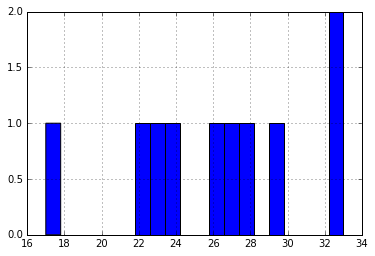

In [89]:
%matplotlib inline
import pandas as pd


df = pd.read_csv("output_eda1",
                 sep='\t',
                header=None)

counts = pd.Series(df[1])
print counts
counts.hist(bins=20)

## HW 5.3.1 OPTIONAL Question:
Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

## HW 5.4  Synonym detection over 2Gig of Data

For the remainder of this assignment you will work with two datasets:

### 1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

- DocA {X:20, Y:30, Z:5}
- DocB {X:100, Y:20}
- DocC {M:5, N:20, Z:5}

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes for the most frequent 10,000 words using co-occurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

==Design notes for (1)==
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

==Design notes for (2)==
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!



In [73]:
!head -n 100 data/googlebooks-eng-all-5gram-20090715-0-filtered.txt \
> data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt

In [141]:
%%writefile src/createStripesJob_1.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import mrjob
import sys
import os
import ast
from math import *
import urllib


class createStripesJob_1(MRJob):

    stopwords = set()
    top10000words = set()
    vocabulary = set()
    
    ## ########################################
    ## THE STEPS BELOW ARE PURELY FOR TESTING
    ## I NEED TO WRITE THE OUTPUT OF THE STRIPE
    ## JOB TO S3
    ## ########################################
    def steps(self):
        return [
            MRStep(mapper_init=self.stripeMapper_init,
                   mapper=self.stripeMapper,
                   reducer=self.stripeReducer
            )
        ]

    def stripeMapper_init(self):
        #with open('/home/cloudera/w261/HW5/data/stopwords.txt', 'r') as f:
        with open('stopwords.txt','r') as f:
            for line in f:
                line = line.strip()
                self.stopwords.add(line)

        #with open('/home/cloudera/w261/HW5/data/top10000words.txt', 'r') as f:
        with open('top10000words.txt','r') as f:
            for line in f:
                line = line.strip()
                line = line.split("\t")
                word = line[0].strip('"')
                self.top10000words.add(word)

        #with open('/home/cloudera/w261/HW5/data/ranked9001-10000words.txt','r') as f:
        with open('ranked9001-10000words.txt','r') as f:
            for line in f:
                line = line.strip()
                line = line.split("\t")
                word = line[0].strip('"')
                self.vocabulary.add(word)
        
    def stripeMapper(self, _, line):
        line = line.strip()
        line = line.split("\t")
        fiveGram = line[0]
        count = int(line[1])
        unigrams = fiveGram.split()
        for token1 in unigrams:
            if token1 in self.top10000words and token1 not in self.stopwords:
                stripe = {}
                for token2 in unigrams:
                    if token1 != token2 and token2 in self.vocabulary and token2 not in self.stopwords:
                        stripe[token2] = count
                if stripe:
                    yield token1, stripe
    def stripeReducer(self, key, value):
        agg_stripe = {}
        doc = key
        for stripe in value:
            for key,value in stripe.iteritems():
                if key in agg_stripe.keys():
                    agg_stripe[key] = agg_stripe[key] + int(value)
                else:
                    agg_stripe[key] = int(value)
        yield doc, agg_stripe

if __name__ == "__main__":
    createStripesJob_1().run()

Overwriting src/createStripesJob_1.py


In [139]:
# !chmod a+x src/createStripesJob_1.py
# !./src/createStripesJob_1.py -r hadoop \
# data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt \
# > output_stripes_31
# !cat output_stripes_31

In [142]:
!chmod a+x src/createStripesJob_1.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/Stripes/ --recursive
!python ~/w261/HW5/src/createStripesJob_1.py -r emr s3://filtered-5grams \
    --output-dir=s3://cerc-w261/HW5/5-2/output/Stripes \
        --file='/home/cloudera/w261/HW5/data/stopwords.txt#stopwords.txt' \
        --file='/home/cloudera/w261/HW5/data/top10000words.txt#top10000words.txt' \
        --file='/home/cloudera/w261/HW5/data/ranked9001-10000words.txt#ranked9001-10000words.txt' \
        --no-output
# !mkdir ~/w261/HW5/output/Stripes
# !aws s3 cp s3://cerc-w261/HW5/5-2/output/Stripes/ output/Stripes --recursive

Using configs in /home/cloudera/.mrjob.conf
Unexpected option emr_cluster_id from /home/cloudera/.mrjob.conf
Unexpected option hadoop from /home/cloudera/.mrjob.conf
Using s3://mrjob-4b78edd1b5baad75/tmp/ as our temp dir on S3
Creating temp directory /tmp/createStripesJob_1.cloudera.20160618.183937.349766
Copying local files to s3://mrjob-4b78edd1b5baad75/tmp/createStripesJob_1.cloudera.20160618.183937.349766/files/...
Created new cluster j-M6JFM1QD6CQH
Waiting for step 1 of 1 (s-KZQTN4GYH01J) to complete...
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING: Configuring cluster software)
  PENDING (cluster is STARTING: Configuring cluster software)
  PENDING (cluster is BOOTSTRAPPING: Running bootstrap actions)
  PENDING (cluster is BOOTSTRAPPING: Running bootstrap actions)
  PENDING 

In [169]:
%%writefile src/cosineSimJob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import mrjob
import sys
import os
import ast
from math import *

class cosineSimJob(MRJob):
    
    stopwords = set()
    top10000words = set()
    vocabulary = set()
    
    def steps(self):
        return [
            MRStep(
                mapper=self.invertedIndexMapper,
                reducer=self.invertedIndexReducer
            ),
            MRStep(
                mapper=self.cosineSimMapper,
                reducer=self.cosineSimReducer
            )
        ]
    
    def invertedIndexMapper(self, _, line):
        inverted_index = {}
        line = line.split("\t")
        key = line[0]
        line = line[1]
        doc = key
        stripe = line
        stripe = ast.literal_eval(stripe)
        length = len(stripe)
        norm_length = sqrt(length)
        for k in stripe.keys():
            stripe[k] = 1
            stripe[k] = float(stripe[k]) / float(norm_length)
            if k not in inverted_index.keys():
                inverted_index[k] = {doc:{"sim":stripe[k]}}
            else:
                inverted_index[k][doc]["sim"] = stripe[k]
        for k2, v2 in inverted_index.iteritems():
            v2[doc]["length"] = length
            yield k2, v2
    def invertedIndexReducer(self, key, line):
        posting_list = {}
        doc = key
        for stripe in line:
        ## under the assumption that we have properly constructed
        ## our inputs, we simply aggregate them as a single dict
        ## in the value
            for key,value in stripe.iteritems():
                posting_list[key] = value
        yield doc, posting_list

    def JaccardSimMapper(self, key, value):
        yield 1,1

    def JaccardSimReducer(self, key, value):
        yield 1,1

    def cosineSimMapper(self, key, value):
        CosineSim = set()
        for key1, value1 in value.iteritems():
            for key2, value2 in value.iteritems():
                if key1 != key2:
                    if frozenset([key1, key2]) not in CosineSim:
                        if key1 < key2:
                            #CosineSim[key1+key2] = value1["sim"] * value2["sim"]
                            CosineSim.add(frozenset([key1, key2]))
                            cosine_similarity = float(value1["sim"]) * float(value2["sim"])
                            yield (key1, key2), cosine_similarity
                        else:
                            #CosineSim[key2+key1] = value1["sim"] * value2["sim"]
                            CosineSim.add(frozenset([key1, key2]))
                            cosine_similarity = float(value1["sim"]) * float(value2["sim"])
                            yield (key2, key1), cosine_similarity

    def cosineSimReducer(self, key, value):
        cosine_similarity = 0
        for v in value:
            cosine_similarity += float(v)
        yield key, cosine_similarity

if __name__ == "__main__":
    cosineSimJob().run()

Writing src/cosineSimJob.py


In [170]:
!chmod a+x src/cosineSimJob.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/CosineSim/ --recursive
!python ~/w261/HW5/src/cosineSimJob.py -r emr s3://cerc-w261/HW5/5-2/output/Stripes/ \
    --output-dir=s3://cerc-w261/HW5/5-2/output/CosineSim \
        --no-output
# !mkdir ~/w261/HW5/output/Stripes
# !aws s3 cp s3://cerc-w261/HW5/5-2/output/Stripes/ output/Stripes --recursive

Using configs in /home/cloudera/.mrjob.conf
Unexpected option emr_cluster_id from /home/cloudera/.mrjob.conf
Unexpected option hadoop from /home/cloudera/.mrjob.conf
Using s3://mrjob-4b78edd1b5baad75/tmp/ as our temp dir on S3
Creating temp directory /tmp/cosineSimJob.cloudera.20160618.210710.539109
Copying local files to s3://mrjob-4b78edd1b5baad75/tmp/cosineSimJob.cloudera.20160618.210710.539109/files/...
Created new cluster j-2V7W9L4EI449N
Waiting for step 1 of 2 (s-2CWK7BKPMMM8D) to complete...
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING: Configuring cluster software)
  PENDING (cluster is STARTING: Configuring cluster software)
  PENDING (cluster is BOOTSTRAPPING: Running bootstrap actions)
  PENDING (cluster is BOOTSTRAPPING: Running bootstrap actions)
  PENDING (cluster is BOOTSTRAPPING: Running bootstrap actions)
  Opening ssh tunnel

In [168]:
!chmod a+x src/createInvertedIndexJob.py
# # !ls data
# !cat data/systems_test_HW54.txt
!python ~/w261/HW5/src/createInvertedIndexJob.py -r local \
data/systems_test_HW54.txt

Using configs in /home/cloudera/.mrjob.conf
Creating temp directory /tmp/createInvertedIndexJob.cloudera.20160618.205737.517667
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/createInvertedIndexJob.cloudera.20160618.205737.517667/output...
["B", "C"]	0.35355339059327373
["A", "B"]	0.816496580927726
["A", "C"]	0.5773502691896258
Removing temp directory /tmp/createInvertedIndexJob.cloudera.20160618.205737.517667...


In [156]:
!chmod a+x src/createInvertedIndexJob.py
#!aws s3 rm s3://cerc-w261/HW5/5-2/output/Stripes/ --recursive
!aws s3 rm s3://cerc-w261/HW5/5-2/output/InvertedIndex/ --recursive
!python ~/w261/HW5/src/createInvertedIndexJob.py -r emr s3://cerc-w261/HW5/5-2/output/Stripes \
    --output-dir=s3://cerc-w261/HW5/5-2/output/InvertedIndex \
        --no-output

Using configs in /home/cloudera/.mrjob.conf
Unexpected option emr_cluster_id from /home/cloudera/.mrjob.conf
Unexpected option hadoop from /home/cloudera/.mrjob.conf
Using s3://mrjob-4b78edd1b5baad75/tmp/ as our temp dir on S3
Creating temp directory /tmp/createInvertedIndexJob.cloudera.20160618.195830.925353
Copying local files to s3://mrjob-4b78edd1b5baad75/tmp/createInvertedIndexJob.cloudera.20160618.195830.925353/files/...
Created new cluster j-14R032S7V7RWW
Waiting for step 1 of 1 (s-S5ZN4GRLPVJX) to complete...
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING)
  PENDING (cluster is STARTING: Configuring cluster software)
  PENDING (cluster is BOOTSTRAPPING: Running bootstrap actions)
  PENDING (cluster is BOOTSTRAPPING: Running bootstrap actions)
  PENDING (cluster is BOOTSTRAPPING: Running bootstrap actions)
  Opening ssh tunnel to resourc

In [71]:
%%writefile src/createStripesJob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import mrjob
import sys
import os
import ast
from math import *

class createStripesJob(MRJob):

    stopwords = set()
    top10000words = set()
    vocabulary = set()
    
    ## ########################################
    ## THE STEPS BELOW ARE PURELY FOR TESTING
    ## I NEED TO WRITE THE OUTPUT OF THE STRIPE
    ## JOB TO S3
    ## ########################################
    def steps(self):
        return [
            MRStep(mapper_init=self.stripeMapper_init,
                   mapper=self.stripeMapper,
                   reducer=self.stripeReducer
            ),
            MRStep(
                mapper=self.invertedIndexMapper,
                reducer=self.invertedIndexReducer
            )
        ]

    def stripeMapper_init(self):
        with open('/home/cloudera/w261/HW5/data/stopwords.txt', 'r') as f:
            for line in f:
                line = line.strip()
                self.stopwords.add(line)

        with open('/home/cloudera/w261/HW5/data/top10000words.txt', 'r') as f:
            for line in f:
                line = line.strip()
                line = line.split("\t")
                word = line[0].strip('"')
                self.top10000words.add(word)

        with open('/home/cloudera/w261/HW5/data/ranked9001-10000words.txt','r') as f:
            for line in f:
                line = line.strip()
                line = line.split("\t")
                word = line[0].strip('"')
                self.vocabulary.add(word)
        
    def stripeMapper(self, _, line):
        line = line.strip()
        line = line.split("\t")
        fiveGram = line[0]
        count = int(line[1])
        unigrams = fiveGram.split()
        for token1 in unigrams:
            if token1 in self.top10000words and token1 not in self.stopwords:
                stripe = {}
                for token2 in unigrams:
                    if token1 != token2 and token2 in self.vocabulary and token2 not in self.stopwords:
                        stripe[token2] = count
                if stripe:
                    yield token1, stripe
    def stripeReducer(self, key, value):
        agg_stripe = {}
        doc = key
        for stripe in value:
            ## LOOKS LIKE THE KEYS IN THE STRIPE ARE
            ## UNICODE STRINGS WATCH OUT FOR THAT SHIT
            ## ALSO
            ## SEEMS LIKE THE STRIPES ARE ALREADY DICTS...
            
#             sys.stderr.write("THIS IS A RAW STRIPE DUDE: %s\n" %stripe)
#             sys.stderr.write("THIS IS THE RAW STRIPE TYPE:\n")
#             sys.stderr.write(type(stripe).__name__)
            
            #stripe = ast.literal_eval(stripe)
            for key,value in stripe.iteritems():
                if key in agg_stripe.keys():
                    agg_stripe[key] = agg_stripe[key] + int(value)
                else:
                    agg_stripe[key] = int(value)
        #yield key, agg_stripe
        yield doc, agg_stripe
    
    def invertedIndexMapper(self, key, line):
        inverted_index = {}
        sys.stderr.write("\nTHIS IS THE SECOND MAPPER'S INPUT KEY\n")
        sys.stderr.write(key)
        sys.stderr.write("\n#######################################\n")
        sys.stderr.write("\nTHIS IS THE SECOND MAPPER'S INPUT LINE\n")
        ## we have figured out that the "line" input here is a dict
        ## fascinating shit... BUT this is good cause we are getting closer
        ## I think that the key is being sent as a string separately
        ## LETS CHECK!!!!!
        sys.stderr.write(str(line))
        sys.stderr.write("\n#######################################\n")
        #line = line.split("\t")
        #doc = line[0]
        doc = key
        #stripe = line[1]
        #stripe = stripe
        #stripe = ast.literal_eval(stripe)
        stripe = line
        length = len(stripe)
        norm_length = sqrt(length)
        for k in stripe.keys():
            stripe[k] = 1
            stripe[k] = float(stripe[k]) / float(norm_length)
            if k not in inverted_index.keys():
                inverted_index[k] = {doc:{"sim":stripe[k]}}
            else:
                inverted_index[k][doc]["sim"] = stripe[k]
        for k2, v2 in inverted_index.iteritems():
            v2[doc]["length"] = length
            #print ("\t".join([key, str(value)]) + "\n")
            yield k2, v2
    def invertedIndexReducer(self, key, line):
        posting_list = {}
        doc = key
        for stripe in line:
        ## under the assumption that we have properly constructed
        ## our inputs, we simply aggregate them as a single dict
        ## in the value
            for key,value in stripe.iteritems():
                posting_list[key] = value
#                 if key in agg_stripe.keys():
#                     agg_stripe[key] = agg_stripe[key] + int(value)
#                 else:
#                     agg_stripe[key] = int(value)
        #yield key, agg_stripe
        # doc is NOT ACTUALLY A DOCUMENT
        # WE ARE ONLY USING IT TO GROUP THE WORDS THAT WE DO(!!)
        # CARE ABOUT... hence we can simply ignore the below 
        # peice of code
        
#         posting_list["*"+doc] = len(posting_list)
        yield doc, posting_list

if __name__ == "__main__":
    createStripesJob().run()

Overwriting src/createStripesJob.py


In [65]:
# !chmod a+x src/createStripesJob.py
# !./src/createStripesJob.py -r hadoop \
# data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt \
# > output_stripes_2
!cat output_stripes_2

"aspiration"	{"*marrow": 2, "marrow": 0.70710678118654746, "*bone": 2, "bone": 0.70710678118654746}
"basin"	{"midst": 1.0, "*midst": 1}
"battle"	{"ensued": 1.0, "fought": 1.0, "*fought": 1, "*ensued": 1}
"belief"	{"necessity": 1.0, "*necessity": 1}
"bit"	{"*farther": 1, "farther": 1.0}
"body"	{"*projected": 1, "projected": 1.0}
"bone"	{"*marrow": 2, "marrow": 0.70710678118654746, "aspiration": 0.70710678118654746, "*aspiration": 2}
"book"	{"*designed": 1, "designed": 1.0}
"branch"	{"*established": 1, "established": 1.0}
"designed"	{"book": 1.0, "*book": 1}
"ensued"	{"battle": 0.70710678118654746, "*battle": 2}
"established"	{"*branch": 1, "branch": 1.0}
"farther"	{"bit": 1.0, "*bit": 1}
"fought"	{"battle": 0.70710678118654746, "*battle": 2}
"marrow"	{"*aspiration": 2, "aspiration": 0.70710678118654746, "*bone": 2, "bone": 0.70710678118654746}
"midst"	{"basin": 1.0, "*basin": 1}
"necessity"	{"*belief": 1, "belief": 1.0}
"projected"	{"body": 1.0, "*body": 1}


In [62]:
# !chmod a+x src/createStripesJob.py
# !./src/createStripesJob.py -r hadoop \
# data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt \
# > output_stripes_1
!cat output_stripes_1

"marrow"	{"*aspiration": 2, "aspiration": 0.70710678118654746}
"bone"	{"*aspiration": 2, "aspiration": 0.70710678118654746}
"midst"	{"basin": 1.0, "*basin": 1}
"fought"	{"battle": 0.70710678118654746, "*battle": 2}
"ensued"	{"battle": 0.70710678118654746, "*battle": 2}
"necessity"	{"*belief": 1, "belief": 1.0}
"farther"	{"bit": 1.0, "*bit": 1}
"projected"	{"body": 1.0, "*body": 1}
"marrow"	{"*bone": 2, "bone": 0.70710678118654746}
"aspiration"	{"*bone": 2, "bone": 0.70710678118654746}
"designed"	{"book": 1.0, "*book": 1}
"established"	{"*branch": 1, "branch": 1.0}
"book"	{"*designed": 1, "designed": 1.0}
"battle"	{"*ensued": 1, "ensued": 1.0}
"branch"	{"*established": 1, "established": 1.0}
"bit"	{"*farther": 1, "farther": 1.0}
"battle"	{"fought": 1.0, "*fought": 1}
"aspiration"	{"*marrow": 2, "marrow": 0.70710678118654746}
"bone"	{"*marrow": 2, "marrow": 0.70710678118654746}
"basin"	{"midst": 1.0, "*midst": 1}
"belief"	{"necessity": 1.0, "*necessity": 1}
"body"	{"*projected": 1, "proj

In [38]:
# !chmod a+x src/createStripesJob.py
# !./src/createStripesJob.py -r hadoop \
# data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt \
# > output_stripes
!cat output_stripes

"aspiration"	{"marrow": 94, "bone": 94}
"basin"	{"midst": 205}
"battle"	{"fought": 82, "ensued": 95}
"belief"	{"necessity": 102}
"bit"	{"farther": 52}
"body"	{"projected": 187}
"bone"	{"marrow": 94, "aspiration": 94}
"book"	{"designed": 77}
"branch"	{"established": 63}
"designed"	{"book": 77}
"ensued"	{"battle": 95}
"established"	{"branch": 63}
"farther"	{"bit": 52}
"fought"	{"battle": 82}
"marrow"	{"aspiration": 94, "bone": 94}
"midst"	{"basin": 205}
"necessity"	{"belief": 102}
"projected"	{"body": 187}


In [114]:
# !head data/top10000words.txt
import sys
import os
import ast
from math import *


stopwords = set()
top10000words = set()
vocabulary = set()
    

with open('data/stopwords.txt', 'r') as f:
    for line in f:
        line = line.strip()
        stopwords.add(line)

with open('data/top10000words.txt', 'r') as f:
    for line in f:
        line = line.strip()
        line = line.split("\t")
        word = line[0].strip('"')
        top10000words.add(word)

with open('data/ranked9001-10000words.txt','r') as f:
    for line in f:
        line = line.strip()
        line = line.split("\t")
        word = line[0].strip('"')
        vocabulary.add(word)

# print vocabulary

with open('data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt','r') as f:
    for line in f:
        line = line.strip()
        line = line.split("\t")
        fiveGram = line[0]
        count = int(line[1])
        unigrams = fiveGram.split()
        for token1 in unigrams:
            if token1 in top10000words and token1 not in stopwords:
                stripe = {}
                for token2 in unigrams:
                    if token1 != token2 and token2 in vocabulary and token2 not in stopwords:
                        stripe[token2] = count
                if stripe:
                    print token1, stripe

basin {'midst': 205}
midst {'basin': 205}
battle {'ensued': 95}
ensued {'battle': 95}
battle {'fought': 82}
fought {'battle': 82}
belief {'necessity': 102}
necessity {'belief': 102}
bit {'farther': 52}
farther {'bit': 52}
body {'projected': 187}
projected {'body': 187}
bone {'marrow': 94, 'aspiration': 94}
marrow {'aspiration': 94, 'bone': 94}
aspiration {'marrow': 94, 'bone': 94}
book {'designed': 77}
designed {'book': 77}
branch {'established': 63}
established {'branch': 63}


## HW 5.5 Evaluation of synonyms that your discovered
In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.4, and use the synonyms function in the accompanying python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

In [172]:
import nltk

## HW5.6 (Optional)

Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

## HW 5.7 (Optional)
There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
>> stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']



test

## HW 5.6 (Optional)
There are many good ways to build our synonym detectors, so for optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

## Hw 5.7 (Optional)
Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?